In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xarray as xr
import os
from scripts.paths import *

In [14]:
dsBrice = "/Users/annek/Documents/RACMO2.3p2/FGRN055/Downscaling_GR/GrIS_topo_icemask_lsm_lon_lat_1km.nc"
dsBrice = xr.open_dataset(dsBrice)
dsBrice

<xarray.Dataset> Size: 145MB
Dimensions:       (time: 1, x: 1496, y: 2700)
Coordinates:
  * time          (time) float32 4B 0.0
  * x             (x) float32 6kB -6.39e+05 -6.38e+05 ... 8.55e+05 8.56e+05
  * y             (y) float32 11kB -3.355e+06 -3.354e+06 ... -6.556e+05
Data variables:
    LON           (y, x) float32 16MB ...
    LAT           (y, x) float32 16MB ...
    Icemask       (y, x) float32 16MB ...
    Promicemask   (y, x) float32 16MB ...
    Topography    (y, x) float32 16MB ...
    GrIS          (y, x) float32 16MB ...
    GIC           (y, x) float32 16MB ...
    grounded_ice  (y, x) float32 16MB ...
    LSM           (y, x) float32 16MB ...
Attributes:
    title:        Masks at 1 km resolution
    institution:  IMAU (Brice Noel)
    grid:         Map Projection:Polar Stereographic Ellipsoid - Map Referenc...
    history:      libUN (2013.05.22) - Fri Oct 26 08:57:13 2018
    netcdf:       4.4.1.1 of Nov 25 2017 10:57:26 $

In [53]:
dsBrice

<xarray.Dataset>
Dimensions:       (time: 1, x: 1496, y: 2700)
Coordinates:
  * time          (time) float32 0.0
  * x             (x) float32 -6.39e+05 -6.38e+05 ... 8.55e+05 8.56e+05
  * y             (y) float32 -3.355e+06 -3.354e+06 ... -6.566e+05 -6.556e+05
Data variables:
    LON           (y, x) float32 ...
    LAT           (y, x) float32 ...
    Icemask       (y, x) float32 ...
    Promicemask   (y, x) float32 ...
    Topography    (y, x) float32 ...
    GrIS          (y, x) float32 ...
    GIC           (y, x) float32 ...
    grounded_ice  (y, x) float32 ...
    LSM           (y, x) float32 ...
Attributes:
    title:        Masks at 1 km resolution
    institution:  IMAU (Brice Noel)
    grid:         Map Projection:Polar Stereographic Ellipsoid - Map Referenc...
    history:      libUN (2013.05.22) - Fri Oct 26 08:57:13 2018
    netcdf:       4.4.1.1 of Nov 25 2017 10:57:26 $

(7,)

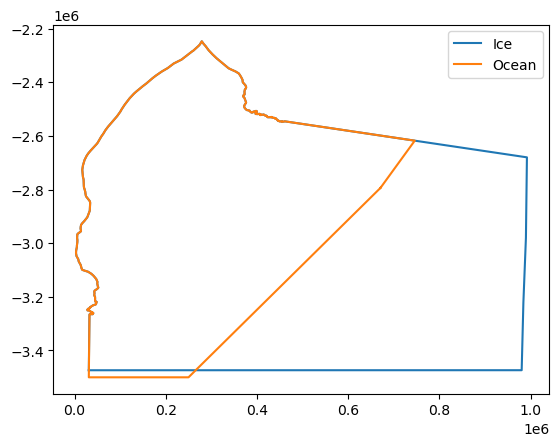

In [9]:
PathSectorsIceOceanPath = "/Users/annek/Documents/fjords_GRL_2022/ice_ocean_sectors.mat"

import scipy.io
import matplotlib.pyplot as plt

# Load the data from the .mat file
data = scipy.io.loadmat(PathSectorsIceOceanPath)

# Extract the 'ice' data
ice_data = data['regions']['ice'][0][0]

# Extract the 'x' and 'y' coordinates
x_ice = ice_data['x'][0][0]
y_ice = ice_data['y'][0][0]



# Plot the 'ice' data
plt.plot(x_ice, y_ice, label='Ice')

# Repeat the process for the 'ocean' data
ocean_data = data['regions']['ocean'][0][0]
x_ocean = ocean_data['x'][0][0]
y_ocean = ocean_data['y'][0][0]
plt.plot(x_ocean, y_ocean, label='Ocean')

# Add a legend
plt.legend()

# Show the plot
plt.show()



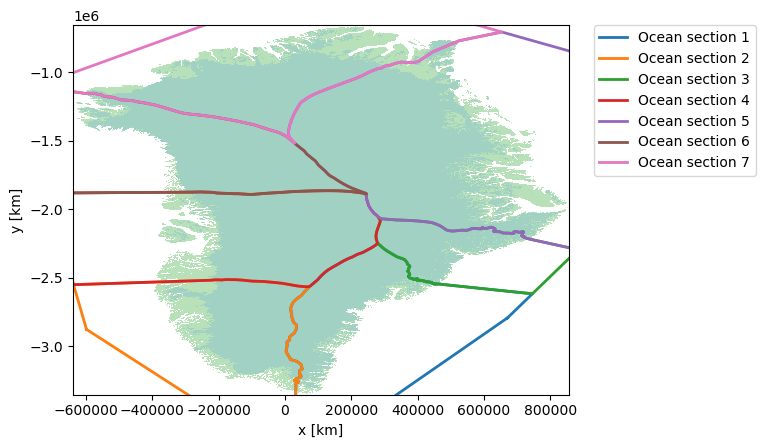

In [260]:
fig,ax = plt.subplots(1,1)
dsBrice['LSM'].where(dsBrice['LSM'] >= 1).plot(ax=ax, alpha=0.5, cmap= 'Greens', add_colorbar=False)
dsBrice['Icemask'].where(dsBrice['Icemask'] >= 1).plot(ax=ax, alpha=0.3, cmap = 'Blues', add_colorbar=False)
ocean_data = np.squeeze(data['regions']['ocean'])
ice_data = np.squeeze(data['regions']['ice'])

for i, section in enumerate(ocean_data):
    x_ocean = section['x'][0][0]
    y_ocean = section['y'][0][0]
    ax.plot(x_ocean, y_ocean, label=f'Ocean section {i+1}', linewidth=2)
    
    # x_ice = ice_data[i]['x'][0][0]
    # y_ice = ice_data[i]['y'][0][0]
    # ax.plot(x_ice, y_ice, label=f'Ice section {i+1}', linestyle='--')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


In [252]:

from shapely.geometry import Point, Polygon

section_numbers = xr.DataArray(np.full((len(dsBrice['y'].values), len(dsBrice['x'].values)), np.nan), 
                               coords={'y': dsBrice['y'].values, 'x': dsBrice['x'].values}, 
                               dims=['y', 'x'])

# Create a list of polygons for the ocean sections
ocean_polygons = [Polygon(list(zip(np.squeeze(section['x'][0][0]), np.squeeze(section['y'][0][0])))) for section in ocean_data]

# Create a list of points from the 'x' and 'y' coordinates in dsBrice
points = [(x, y) for x in dsBrice['x'].values for y in dsBrice['y'].values]




# Loop over all points
for point_tuple in tqdm(points):
    point_obj = Point(point_tuple)

    # Check which ocean section the point is in
    for i, polygon in enumerate(ocean_polygons):
        if polygon.contains(point_obj):
            # Assign the section number to the corresponding location in the data array
            section_numbers.loc[dict(x=point_tuple[0], y=point_tuple[1])] = i + 1




100%|██████████| 4039200/4039200 [22:34<00:00, 2981.11it/s] 


In [7]:
# section_numbers.to_dataset(name='section_numbers_slater').to_netcdf(os.path.join(pathDataTemp, 'section_numbers_slater.nc'))
section_numbers = xr.open_dataarray(os.path.join(pathDataTemp, 'section_numbers_slater.nc'))

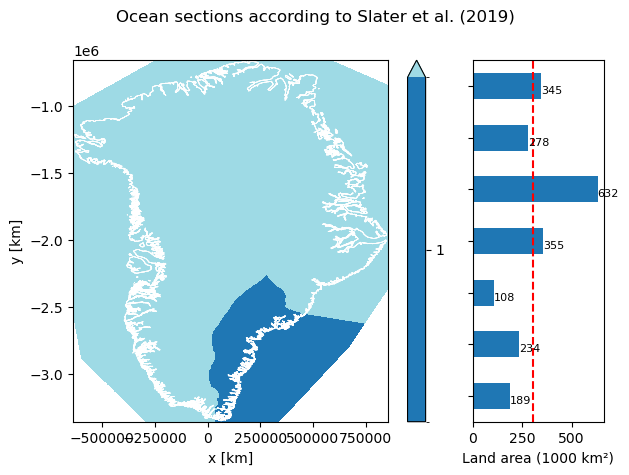

In [15]:
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})
sections = section_numbers.plot.contourf(levels=np.arange(0.5, len(ocean_data) + 1.5, 1), cmap='tab20', add_colorbar=False, ax=axs[0])
dsBrice['LSM'].plot.contour(ax=axs[0], colors='white', linewidths=0.5,)
# change labels in colorbar
cbar = plt.colorbar(sections)
cbar.set_ticks(np.arange(1, len(ocean_data) + 1))
bar_plot = dsBrice['LSM'].groupby(section_numbers).sum().to_dataframe().divide(1000).plot.barh(ax=axs[1], legend=False)
axs[1].set_xlabel('Land area (1000 km²)')
# write values on bars
for i in axs[1].patches:
    axs[1].text(i.get_width() + 0.1, i.get_y() + 0.1, f'{i.get_width():.0f}', fontsize=8)
# draw vertical line for average value
average_area = dsBrice['LSM'].groupby(section_numbers).sum().mean().values/1000
axs[1].axvline(average_area, color='red', linestyle='--', label=f'{average_area:.0f}')
axs[1].set_ylabel("")
axs[1].set_yticklabels([])
fig.suptitle('Ocean sections according to Slater et al. (2019)')
plt.tight_layout()


In [13]:
dsBrice

'/Users/annek/Documents/RACMO2.3p2/FGRN055/Downscaling_GR/GrIS_topo_icemask_lsm_lon_lat_1km.nc'

In [454]:
shapefile_CE = "/Users/annek/Documents/QGreenland_v3.0.0/new_CE_new_proj.shp"

import geopandas as gpd

# Load the shapefile
gdf = gpd.read_file(shapefile_CE)
gdf_CE_extend = gdf
# Print the geometry
print(gdf.geometry)



0    POLYGON ((538235.512 -1858717.976, 585876.179 ...
Name: geometry, dtype: geometry


In [457]:
# Get the polygon for section number 5


# points_in_section_5 = [(x, y) for x in dsBrice['x'].values for y in dsBrice['y'].values if section_numbers.loc[dict(x=x, y=y)] == 5]
points_in_section_5 = [(x, y) for x in dsBrice['x'].where(section_numbers == 5).values for y in dsBrice['y'].where(section_numbers == 5).values]
extended_CE = xr.DataArray(np.full((len(dsBrice['y'].values), len(dsBrice['x'].values)), np.nan), 
                               coords={'y': dsBrice['y'].values, 'x': dsBrice['x'].values}, 
                               dims=['y', 'x'])

# points_in_section_5 = points



  0%|          | 0/942161 [00:00<?, ?it/s]


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [473]:
# Loop over all points
for point_tuple in tqdm(points_in_section_5):
    point_obj = Point(point_tuple)

    if gdf_CE_extend.contains(point_obj).any():
        # Assign the section number to the corresponding location in the data array
        extended_CE.loc[dict(x=point_tuple[0], y=point_tuple[1])] = 3

gdf_CE_extend

100%|██████████| 942161/942161 [01:45<00:00, 8912.60it/s] 


,id,geometry
0,1,"POLYGON ((538235.512 -1858717.976, 585876.179 ..."


In [459]:

dsBasinsMoug = xr.open_dataset("/Users/annek/Documents/RACMO2.3p2/FGRN055/Downscaling_GR/GrIS_topo_icemask_lsm_tundra_basins_ocean_lon_lat_1km.nc")
dsBasinsMoug

# mask where Icemask is >=1 and 
mask_Moug_CE_Ice = (dsBasinsMoug['GrIS'] >= 1) &(dsBasinsMoug['Basins_All_Greenland'] == 3)
daMougCE_Ice = dsBasinsMoug["Basins_All_Greenland"].where(mask_Moug_CE_Ice)



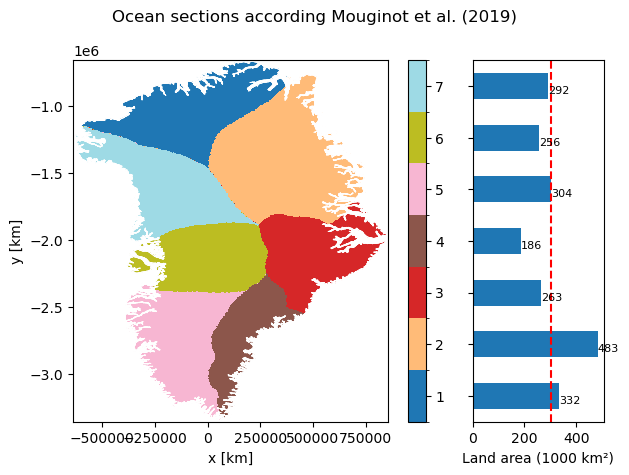

In [460]:
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})
sections = dsBasinsMoug['Basins_All_Greenland'].plot.contourf(levels=np.arange(0.5, 7 + 1.5, 1), cmap='tab20', add_colorbar=False, ax=axs[0])
dsBrice['LSM'].plot.contour(ax=axs[0], colors='white', linewidths=0.5,)
# change labels in colorbar
cbar = plt.colorbar(sections)
cbar.set_ticks(np.arange(1, len(ocean_data) + 1))
bar_plot = dsBrice['LSM'].groupby(dsBasinsMoug['Basins_All_Greenland']).sum().to_dataframe().divide(1000).plot.barh(ax=axs[1], legend=False)
axs[1].set_xlabel('Land area (1000 km²)')
# write values on bars
for i in axs[1].patches:
    axs[1].text(i.get_width() + 0.1, i.get_y() + 0.1, f'{i.get_width():.0f}', fontsize=8)
# draw vertical line for average value
average_area = dsBrice['LSM'].groupby(dsBasinsMoug['Basins_All_Greenland']).sum().mean().values/1000
axs[1].axvline(average_area, color='red', linestyle='--', label=f'{average_area:.0f}')
axs[1].set_ylabel("")
axs[1].set_yticklabels([])
fig.suptitle('Extended sections according Mouginot et al. (2019)')
plt.tight_layout()


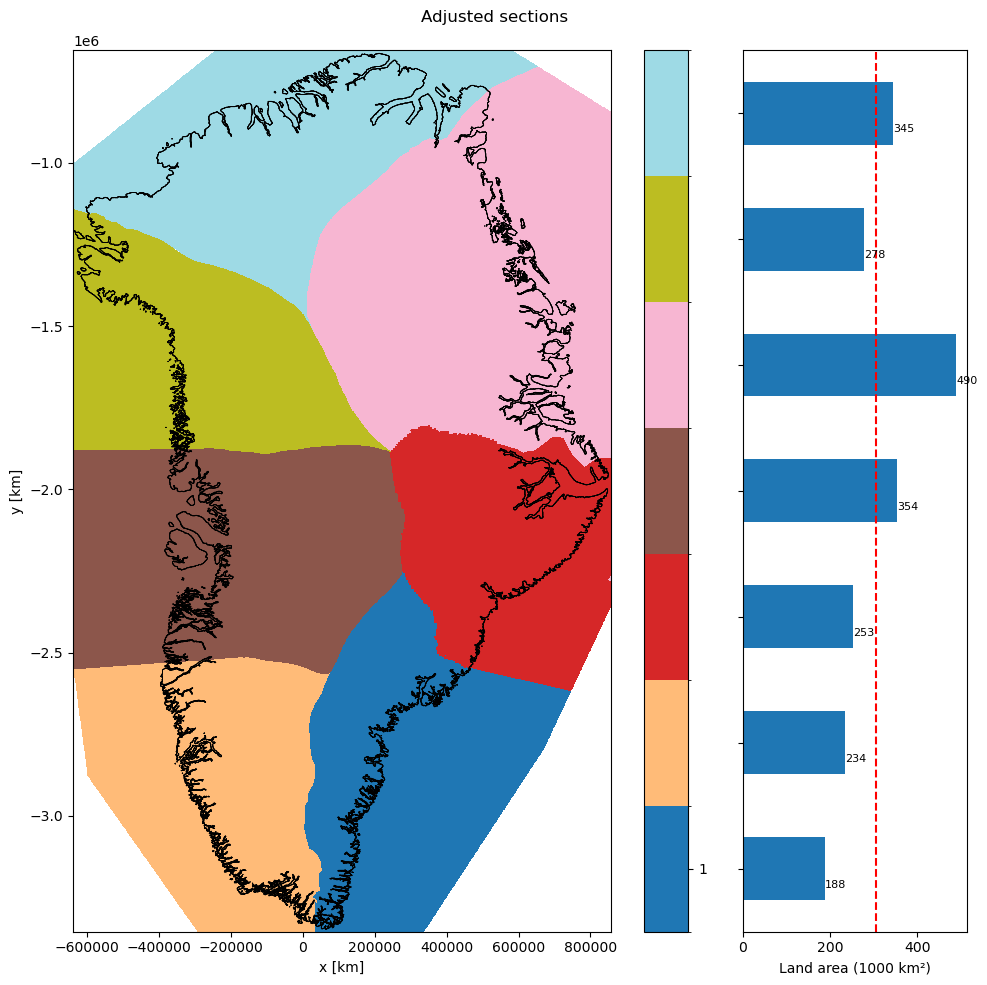

In [18]:
# # Create a copy of section_numbers
# adjusted_sections = section_numbers.copy()
# # Update the values in adjusted_sections with the values in extended_CE
# adjusted_sections.values[extended_CE.values > 0] = 3
# adjusted_sections.values[daMougCE_Ice.values==3] = 3

fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(10, 10))
sections = adjusted_sections.plot.imshow(levels=np.arange(0.5, 7 + 1.5, 1), cmap='tab20', add_colorbar=False, ax=axs[0])
dsBrice['LSM'].plot.contour(ax=axs[0], colors='black', linewidths=0.5,)
# dsBasinsMoug["GrIS"].where(dsBasinsMoug["GrIS"]>=1).plot.contourf(ax=axs[0], cmap='coolwarm', alpha=0.5, add_colorbar=False)
cbar = plt.colorbar(sections)
cbar.set_ticks(np.arange(1, len(ocean_data) + 1))

bar_plot = dsBrice['LSM'].groupby(adjusted_sections).sum().to_dataframe().divide(1000).plot.barh(ax=axs[1], legend=False)
axs[1].set_xlabel('Land area (1000 km²)')
# write values on bars
for i in axs[1].patches:
    axs[1].text(i.get_width() + 0.1, i.get_y() + 0.1, f'{i.get_width():.0f}', fontsize=8)
# draw vertical line for average value
average_area = dsBrice['LSM'].groupby(section_numbers).sum().mean().values/1000
axs[1].axvline(average_area, color='red', linestyle='--', label=f'{average_area:.0f}')
axs[1].set_ylabel("")
axs[1].set_yticklabels([])
fig.suptitle('Adjusted sections')
plt.tight_layout()


<xarray.DataArray 'section_numbers_adjusted' (y: 2700, x: 1496)> Size: 32MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y        (y) float32 11kB -3.355e+06 -3.354e+06 ... -6.566e+05 -6.556e+05
  * x        (x) float32 6kB -6.39e+05 -6.38e+05 -6.37e+05 ... 8.55e+05 8.56e+05

In [49]:
import matplotlib.colors as mcolors
# Define the colors for the colormap
percentage = [0.2, 0.8]
colors = [(percentage[0], percentage[0], percentage[0]), (percentage[1], percentage[1], percentage[1])]
# Create the colormap
CustomGrey = mcolors.LinearSegmentedColormap.from_list("CustomGrey", colors[::-1])

In [52]:
pathFigures

'/Users/annek/Library/CloudStorage/OneDrive-SharedLibraries-NIOZ/PhD Anneke Vries - General/freshwaterII/results/figures/'

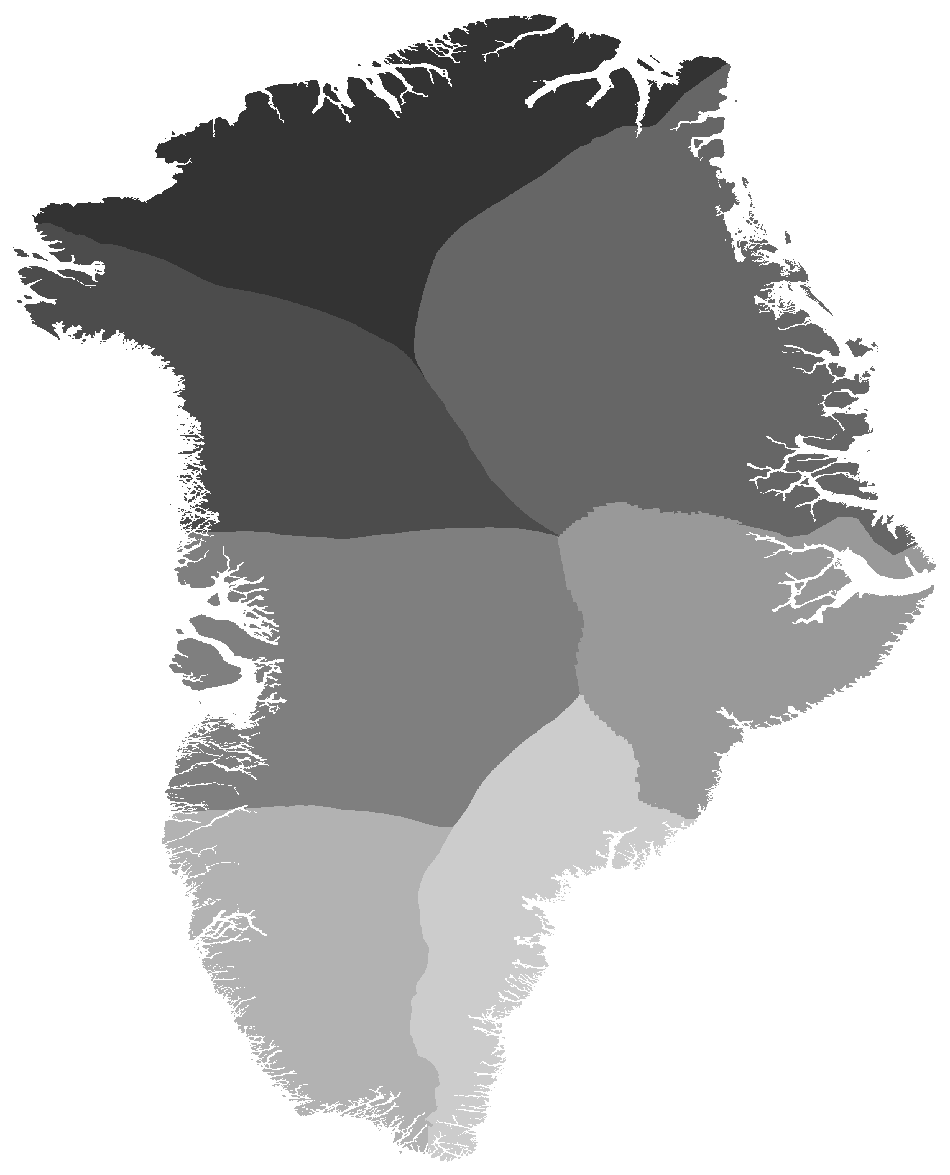

In [53]:
adjusted_sections_land = adjusted_sections.where(dsBrice['LSM']==1)
fig, axs = plt.subplots(1, 1, figsize=(12, 15))
sections = adjusted_sections_land.plot.imshow(levels=np.arange(0.5, 7 + 1.5, 1), cmap=CustomGrey, add_colorbar=False, ax=axs)

spineloc = ['top', 'right', 'left', 'bottom']
for spine in spineloc:
    axs.spines[spine].set_visible(False)
axs.xaxis.set_ticks([])
axs.yaxis.set_ticks([])
# remove labels
axs.set_xlabel("")
axs.set_ylabel("")

# save as svg with transparent background
plt.savefig(os.path.join(pathFigures,'method',  'sections_adjusted.svg'), format='svg', bbox_inches='tight', transparent=True)


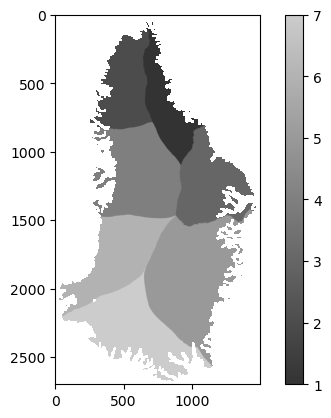

In [30]:
import matplotlib.pyplot as plt

# Use the colormap
plt.imshow(adjusted_sections_land, cmap=cmap)
plt.colorbar()
plt.show()

In [462]:
dict_region_names_slater = {1: "SE", 2: "SW", 3: "CE", 4: "CW", 5: "NE", 6: "NW", 7: "NO"}

In [17]:
# adjusted_sections.to_dataset(name='section_numbers_adjusted').to_netcdf(os.path.join(pathDataTemp, 'adjusted_section_numbers_slater.nc'))
adjusted_sections = xr.open_dataarray(os.path.join(pathDataTemp, 'adjusted_section_numbers_slater.nc'))

In [464]:
dsFjord = "/Users/annek/Documents/RACMO2.3p2/FGRN055/Downscaling_GR/masks1k.nc"
dsFjord = xr.open_dataset(dsFjord)['fjords']
dsFjord['x'] = dsBrice['x']
dsFjord['y'] = dsBrice['y']

In [476]:
dfAreaLand =  dsBrice['LSM'].groupby(adjusted_sections).sum().to_dataframe()
dfAreaIce = dsBrice['Promicemask'].where(dsBrice['Promicemask'] < 1,1).groupby(adjusted_sections).sum().to_dataframe().rename(columns={'Promicemask': 'Ice'})
dfAreaTundra = (dfAreaLand - dfAreaIce.values).rename(columns={'LSM': 'Tundra'})
dfAreaFjord = dsFjord.groupby(adjusted_sections).sum().to_dataframe().rename(columns={'fjords': 'Fjord'})

# combine the dataframes
dfAreaFjord = pd.concat([dfAreaLand, dfAreaIce, dfAreaTundra, dfAreaFjord], axis=1)
# rename index to region names
dfAreaFjord.index = [dict_region_names_slater[i] for i in dfAreaFjord.index]
dfAreaFjord.to_csv(os.path.join(pathDataTemp, 'area_per_region.csv'))

<Axes: >

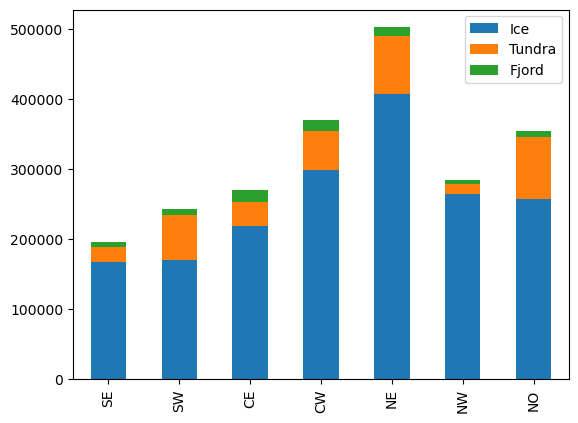

In [477]:
fig, axs = plt.subplots(1, 1)
dfAreaFjord.iloc[:,1:].plot.bar(stacked=True, ax=axs)
# for label uses dict_region_names_slater
# axs.set_xticklabels([dict_region_names_slater[i] for i in dfAreaFjord.index], rotation=0)
# annotate Tundra


In [467]:
dfAreaFjord

,LSM,Ice,Tundra,Fjord
SE,188404.0,167590.0,20814.0,7439
SW,234067.0,170216.0,63851.0,9206
CE,215217.0,208415.0,6802.0,1600
CW,354294.0,298625.0,55669.0,14891
NE,527675.0,417229.0,110446.0,26972
NW,278445.0,264189.0,14256.0,4972
NO,345287.0,256435.0,88852.0,9281


Text(0.5, 1.0, 'Area distribution per sector in %')

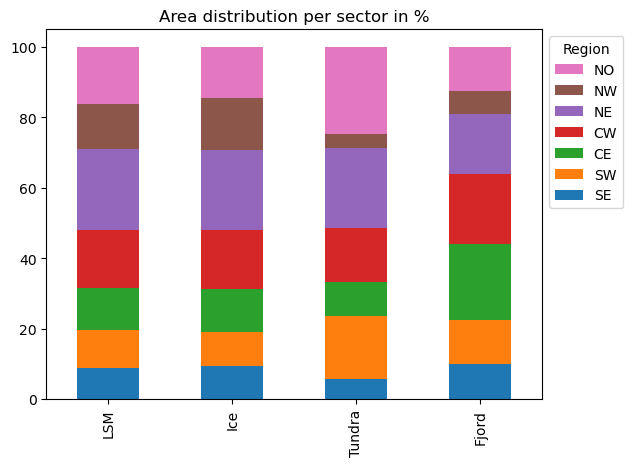

In [479]:
fig, axs = plt.subplots(1, 1)
(dfAreaFjord/dfAreaFjord.sum()*100).T.plot.bar(stacked=True, ax=axs)

axs.legend(dict_region_names_slater.values(), title='Region')
# do legend in reverse order
handles, labels = axs.get_legend_handles_labels()
axs.legend(reversed(handles), reversed(labels), title='Region', loc='upper left', bbox_to_anchor=(1, 1))
axs.set_title('Area distribution per sector in %')

In [9]:
import xarray as xr
since_1940 = "/Volumes/science/projects/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Annual/runoff.1958-2023.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc.gz"
Annual_runoff = xr.open_dataset(since_1940, decode_times=False)



<xarray.DataArray 'runoffcorr' (time: 66, y: 2700, x: 1496)>
[266587200 values with dtype=float32]
Coordinates:
  * time     (time) float32 0.0 1.0 2.0 3.0 4.0 ... 62.46 63.46 64.46 65.46
  * x        (x) float32 -6.39e+05 -6.38e+05 -6.37e+05 ... 8.55e+05 8.56e+05
  * y        (y) float32 -3.355e+06 -3.354e+06 ... -6.566e+05 -6.556e+05
Attributes:
    standard_name:  Downscaled_runoff
    long_name:      Downscaled runoff
    units:          mmWE
    actual_range:   [    0.    15083.506]

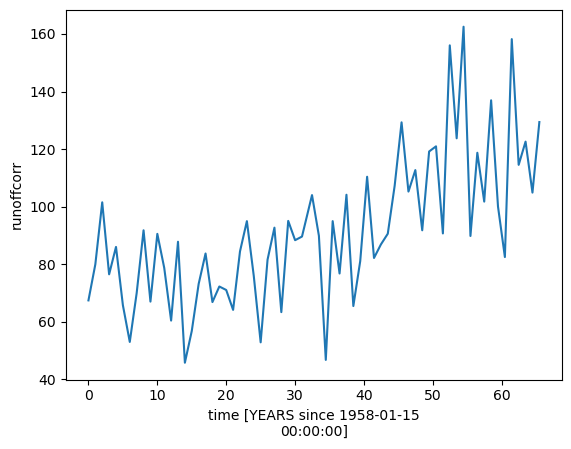

In [41]:
Annual_runoff['runoffcorr'].mean(dim=['x', 'y']).plot()

In [45]:


import pandas as pd
# can you make make a time array where you do the year 1958 + 'time' in years
Annual_runoff




<xarray.Dataset>
Dimensions:     (time: 66, x: 1496, y: 2700)
Coordinates:
  * time        (time) float32 0.0 1.0 2.0 3.0 4.0 ... 62.46 63.46 64.46 65.46
  * x           (x) float32 -6.39e+05 -6.38e+05 -6.37e+05 ... 8.55e+05 8.56e+05
  * y           (y) float32 -3.355e+06 -3.354e+06 ... -6.566e+05 -6.556e+05
Data variables:
    runoffcorr  (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    CDI:          Climate Data Interface version 2.3.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  IMAU (Brice Noel)
    title:        Annual cumulated field, B. Noel (IMAU)
    netcdf:       4.4.1.1 of Nov 25 2017 10:57:26 $
    NCO:          netCDF Operators version 4.8.0 (Homepage = http://nco.sf.ne...
    CDO:          Climate Data Operators version 2.3.0 (https://mpimet.mpg.de...

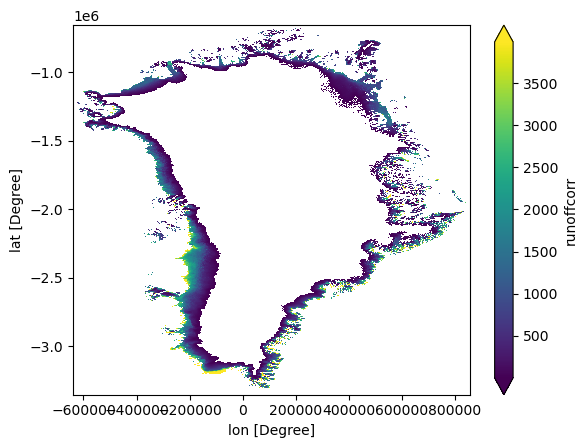

In [22]:
# can you make a plot with runoff corr with average over time
# can you hide zero values

mean_runoff = Annual_runoff['runoffcorr'].mean(dim='time')
mean_runoff.where(mean_runoff > 0.01).plot(robust=True)

In [73]:
# for every data variable count how many are 1
for var in dsBrice.data_vars:
    print(f'{var}: {dsBrice[var].where(dsBrice[var] == 1).count().values}')
    # print percent relative to LSM count
    print(f'{dsBrice[var].where(dsBrice[var] == 1).count().values/dsBrice["LSM"].where(dsBrice["LSM"] == 1).count().values*100:.1f}%\n')


LON: 0
0.0%

LAT: 0
0.0%

Icemask: 1782705
83.2%

Promicemask: 60639
2.8%

Topography: 6954
0.3%

GrIS: 1700836
79.4%

GIC: 81869
3.8%

grounded_ice: 1840726
85.9%

LSM: 2143395
100.0%



In [67]:
dsBrice.GrIS.where(dsBrice.GrIS == 1).count()/dsBrice.LSM.where(dsBrice.LSM==1).count()

<xarray.DataArray ()>
array(0.79352429)